# Forecasting with an RNN

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude=amplitude)

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Simple RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 2s 30ms/step - loss: 50.4896 - mae: 50.9890
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 21.5391 - mae: 22.0362
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 16.4559 - mae: 16.9521
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 12.3444 - mae: 12.8270
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 11.0349 - mae: 11.5265
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 9.2118 - mae: 9.6907
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 8.2313 - mae: 8.6392
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 7.9267 - mae: 8.3910
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 7.7075 - mae: 8.1778
Epoch 10/100
8/8 [==============================] - 0s 25ms/step - loss: 7.3149 - mae: 7.7869
Epoch 11/100
8/8 [==============================] - 0s 25ms

(1e-07, 0.0001, 0.0, 30.0)

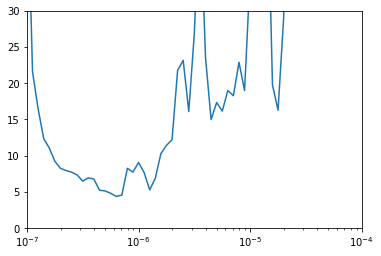

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 2s 85ms/step - loss: 53.0682 - mae: 53.5678 - val_loss: 56.0218 - val_mae: 56.5218
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 2/500
8/8 [==============================] - 0s 42ms/step - loss: 34.5547 - mae: 35.0523 - val_loss: 21.7325 - val_mae: 22.2306
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 3/500
8/8 [==============================] - 0s 43ms/step - loss: 19.3263 - mae: 19.8229 - val_loss: 28.6856 - val_mae: 29.1856
Epoch 4/500
8/8 [==============================] - 0s 42ms/step - loss: 11.9401 - mae: 12.4275 - val_loss: 17.3416 - val_mae: 17.8416
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 5/500
8/8 [==============================] - 0s 42ms/step - loss: 15.6306 - mae: 16.1290 - val_loss: 8.1786 - val_mae: 8.6761
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 6/500
8/8 [==============================] - 0s 41ms/step - loss: 12.0588 - mae: 12.5498 - val_loss: 7

In [9]:
model = keras.models.load_model("my_checkpoint")

In [10]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:,0]

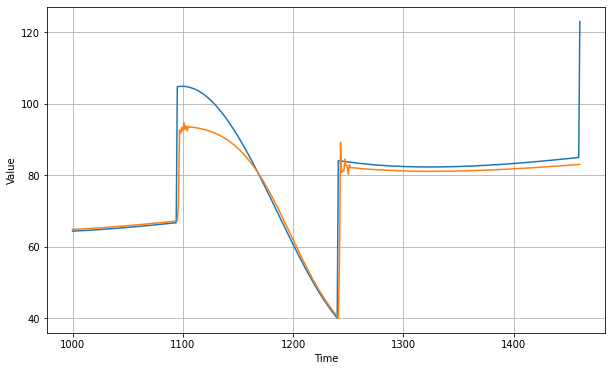

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.3825016

## Sequence-to-Sequence Forecasting

In [13]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds= tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w:w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w:(w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [14]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 1s 25ms/step - loss: 52.6683 - mae: 53.1680
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 24.1949 - mae: 24.6916
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 20.9813 - mae: 21.4766
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 17.9917 - mae: 18.4806
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 15.3250 - mae: 15.8060
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 14.2764 - mae: 14.7609
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 13.0575 - mae: 13.5249
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 12.4771 - mae: 12.9277
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 11.9337 - mae: 12.3679
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 11.4711 - mae: 11.8926
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

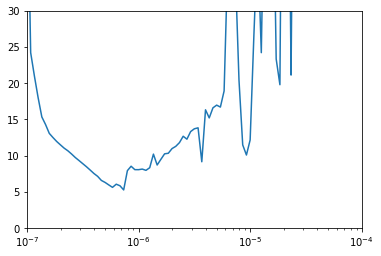

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 2s 75ms/step - loss: 55.2482 - mae: 55.7472 - val_loss: 16.4813 - val_mae: 16.9793
Epoch 2/500
8/8 [==============================] - 0s 42ms/step - loss: 33.7522 - mae: 34.2494 - val_loss: 21.1187 - val_mae: 21.6167
Epoch 3/500
8/8 [==============================] - 0s 43ms/step - loss: 26.6146 - mae: 27.1112 - val_loss: 37.4955 - val_mae: 37.9943
Epoch 4/500
8/8 [==============================] - 0s 40ms/step - loss: 19.6999 - mae: 20.1962 - val_loss: 26.0259 - val_mae: 26.5258
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 15.1073 - mae: 15.5997 - val_loss: 10.3615 - val_mae: 10.8451
Epoch 6/500
8/8 [==============================] - 0s 41ms/step - loss: 12.2220 - mae: 12.7092 - val_loss: 12.2799 - val_mae: 12.7764
Epoch 7/500
8/8 [==============================] - 0s 42ms/step - loss: 10.6667 - mae: 11.1519 - val_loss: 9.6335 - val_mae: 10.1285
Epoch 8/500
8/8 [==============================] - 0s 42ms/step

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

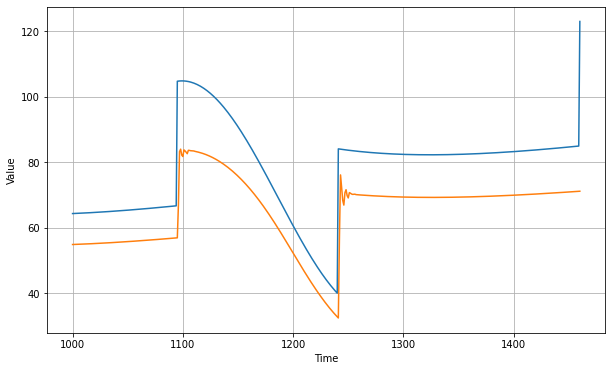

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

12.770759